### conv1 → pool → conv2 → pool → conv3 → pool

### → flatten → linear(512) → ReLU → linear(512) → ReLU → linear(10)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [6]:
class CNNWithLinear512(nn.Module):
    def __init__(self):
        super(CNNWithLinear512, self).__init__()
        # Convolution layers
        self.conv1 = nn.Conv2d(1, 2, kernel_size=3, padding=1)   # (2, 28, 28)
        self.pool1 = nn.MaxPool2d(2, 2)                          # (2, 14, 14)

        self.conv2 = nn.Conv2d(2, 4, kernel_size=3, padding=1)   # (4, 14, 14)
        self.pool2 = nn.MaxPool2d(2, 2)                          # (4, 7, 7)

        self.conv3 = nn.Conv2d(4, 2, kernel_size=3, padding=1)   # (2, 7, 7)
        self.pool3 = nn.MaxPool2d(1, 1)                          # (2, 7, 7)

        # Fully connected layers
        self.fc1 = nn.Linear(2 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        # Convolution + Activation + Pooling
        self.feature1 = F.relu(self.conv1(x))
        x = self.pool1(self.feature1)

        self.feature2 = F.relu(self.conv2(x))
        x = self.pool2(self.feature2)

        self.feature3 = F.relu(self.conv3(x))
        x = self.pool3(self.feature3)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # 10-class output (logits)
        return x


In [8]:
# 시각화 함수
def plot_feature_maps(feature_maps, title_prefix):
    num_channels = feature_maps.shape[1]
    plt.figure(figsize=(15, 3))
    for i in range(num_channels):
        plt.subplot(1, num_channels, i + 1)
        plt.imshow(feature_maps[0, i].detach().cpu().numpy(), cmap='gray')
        plt.title(f"{title_prefix} #{i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
# ✅ 3. 데이터 로더
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

In [10]:
# ✅ 4. 학습 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNWithLinear512().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
# ✅ 5. 학습 루프
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"[Epoch {epoch+1}] Loss: {running_loss / len(train_loader):.4f} | Acc: {100 * correct / total:.2f}%")

Epoch 1/5: 100%|██████████| 938/938 [00:14<00:00, 63.07it/s]


[Epoch 1] Loss: 0.4831 | Acc: 83.13%


Epoch 2/5: 100%|██████████| 938/938 [00:11<00:00, 84.39it/s]


[Epoch 2] Loss: 0.1134 | Acc: 96.41%


Epoch 3/5: 100%|██████████| 938/938 [00:11<00:00, 84.57it/s]


[Epoch 3] Loss: 0.0816 | Acc: 97.38%


Epoch 4/5: 100%|██████████| 938/938 [00:11<00:00, 85.09it/s]


[Epoch 4] Loss: 0.0668 | Acc: 97.90%


Epoch 5/5: 100%|██████████| 938/938 [00:11<00:00, 84.27it/s]

[Epoch 5] Loss: 0.0548 | Acc: 98.22%


In [12]:
# 평가 루프
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

print(f"[Test Accuracy] {100 * test_correct / test_total:.2f}%")

[Test Accuracy] 97.61%


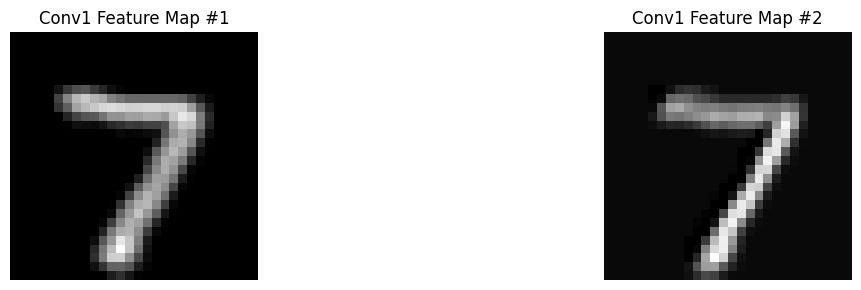

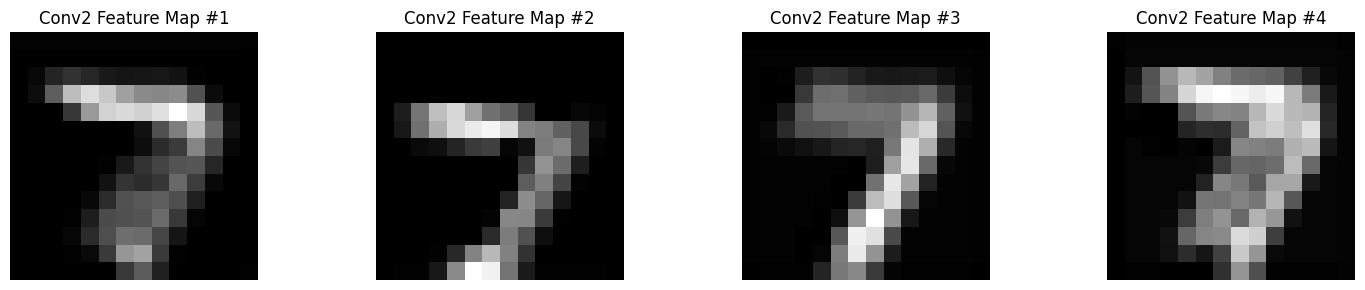

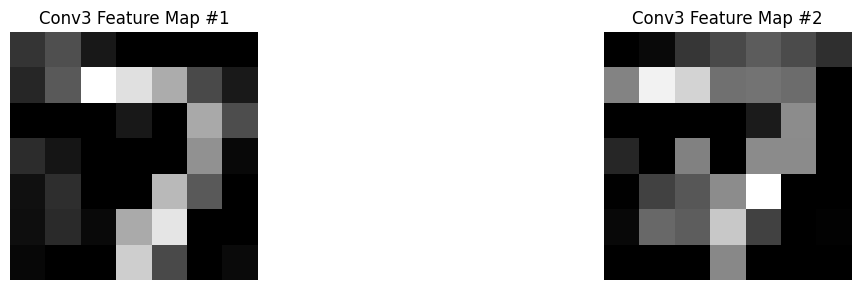

In [13]:
# Feature Map 시각화 (테스트 이미지 하나)
sample_img, _ = test_data[0]
model.eval()
with torch.no_grad():
    _ = model(sample_img.unsqueeze(0).to(device))

plot_feature_maps(model.feature1, "Conv1 Feature Map")
plot_feature_maps(model.feature2, "Conv2 Feature Map")
plot_feature_maps(model.feature3, "Conv3 Feature Map")

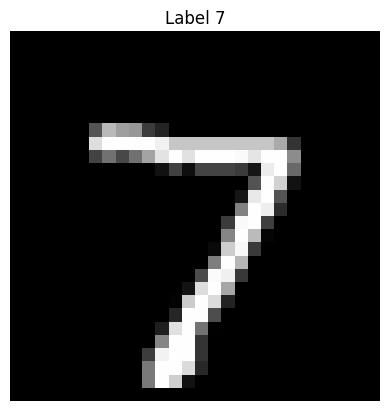

In [23]:
# 예측 코드 (예: 테스트셋 첫 번째 이미지)
# 테스트셋에서 이미지 1장 가져오기
sample_img, sample_label = test_data[0]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"Label {sample_label}")
plt.axis('off')
plt.show()


In [15]:
# 모델을 사용한 예측
model.eval()
with torch.no_grad():
    sample_input = sample_img.unsqueeze(0).to(device)  # 배치 차원 추가
    output = model(sample_input)
    pred_label = output.argmax(dim=1).item()

In [16]:
# 결과 출력
print(f"실제 정답 라벨: {sample_label}")
print(f"모델 예측 라벨: {pred_label}")

실제 정답 라벨: 7
모델 예측 라벨: 7


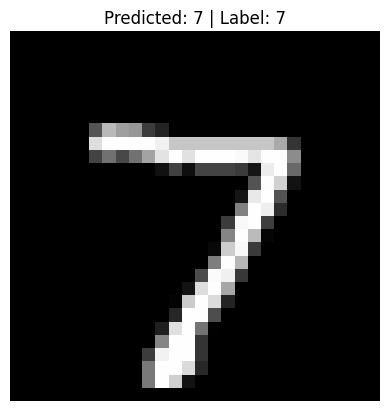

In [24]:
# 이미지 시각화
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"Predicted: {pred_label} | Label: {sample_label}")
plt.axis('off')
plt.show()